# WEO data cleaning and reshaping

This notebook loads WEO data, filters to selected indicators, cleans numeric values, pivots to a panel (Country × Year) with indicators as columns, adds a global recession flag, drops incomplete years, and writes a cleaned CSV.

In [109]:
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score

# File handling
import csv
from pathlib import Path

## Load Data

In [110]:
p = Path(r"data.csv")
if not p.exists():
    raise FileNotFoundError(p)

# detect encoding (fallback to latin-1) and sample for delimiter sniffing
encoding = "utf-8"
try:
    sample = p.read_text(encoding=encoding)[:8192]
except UnicodeDecodeError:
    encoding = "latin-1"
    sample = p.read_text(encoding=encoding)[:8192]

try:
    delim = csv.Sniffer().sniff(sample).delimiter
except Exception:
    delim = ","

df = pd.read_csv(p, sep=delim, encoding=encoding, low_memory=False, parse_dates=True)
print("shape:", df.shape)
df.head()

shape: (8626, 61)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2022,2023,2024,2025,2026,2027,2028,2029,2030,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,032.712","1,056.123",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,Units,"See notes for: Gross domestic product, consta...",NaN,...,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,283.442","1,350.910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,86.149,91.272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0


In [111]:
# count columns
print("Number of columns:", df.shape[1])

# list column names
print("Columns:", df.columns.tolist())

# counts of non-null values per column (good for spotting missing data)
print(df.count().sort_values(ascending=False))

Number of columns: 61
Columns: ['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 'Estimates Start After']
WEO Country Code      8625
ISO                   8624
WEO Subject Code      8624
Country               8624
Subject Descriptor    8624
                      ... 
1984                  4104
1983                  4079
1982                  4039
1981                  3995
1980                  3861
Length: 61, dtype: int64


Lets drop unnecessary columns

In [112]:
df.drop(columns=["WEO Country Code", "ISO","Country/Series-specific Notes", "Subject Notes", "Units", "Scale", "Estimates Start After", "Subject Descriptor" ], inplace=True)

codes = {"NGSD_NGDP", "NGDPRPC", "PCPI", "TM_RPCH","TX_RPCH", "LP","GGR_NGDP","GGX_NGDP","GGXCNL_NGDP","GGSB_NPGDP","GGXONLB_NGDP","GGXWDN_NGDP","BCA_NGDPD"}
col = "WEO Subject Code"

if col not in df.columns:
    raise KeyError(f"Column {col!r} not found in dataframe")

df = df[df[col].astype(str).str.strip().isin(codes)].copy()
print("shape after filter:", df.shape)
df

shape after filter: (2548, 53)


,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
6,NGDPRPC,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"27,467.825","25,101.133","25,044.069",NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NGSD_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.931,-1.863,-5.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PCPI,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.038,143.822,132.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,TM_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-30.012,29.820,14.971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,TX_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.529,30.217,-2.680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8612,GGXCNL_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.225,-4.877,-5.320,-2.060,-0.504,0.441,0.886,0.996,1.134,1.166
8614,GGSB_NPGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8616,GGXONLB_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.573,-4.695,-5.198,-1.096,0.537,1.529,1.948,2.028,2.108,2.108
8618,GGXWDN_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Clean up the data

In [113]:
# --- Step 1: Identify year columns ---
year_cols = df.columns[2:]  # after WEO Subject Code and Country

# --- Step 2: Clean numeric formatting ---
df[year_cols] = df[year_cols].replace({',': ''}, regex=True)
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")

# --- Step 3: Clean country names ---
df["Country"] = (
    df["Country"]
    .str.replace(" ", "_")
    .str.replace("'", "")
    .str.replace("-", "_")
)

# --- Step 4: Melt into long format ---
df_long = df.melt(id_vars=["WEO Subject Code", "Country"],
                  var_name="Year", value_name="Value")

# --- Step 5: Keep only valid year rows ---
df_long["Year"] = df_long["Year"].astype(str).str.strip()
df_long = df_long[df_long["Year"].str.fullmatch(r"\d{4}")].copy()
df_long["Year"] = df_long["Year"].astype(int)

# --- Step 6: Clean numeric values ---
df_long["Value"] = (
    df_long["Value"].astype(str)
    .str.replace(",", "")
    .replace({"": None, "nan": None})
    .astype(float)
)

# --- Step 7: Pivot using WEO Subject Code as columns ---
df_pivot = df_long.pivot_table(
    index=["Country", "Year"],
    columns="WEO Subject Code",   # use NGDPD, PCPI, etc.
    values="Value",
    aggfunc="first"
).reset_index()

# --- Step 8: Finalize ---
df_pivot.columns.name = None
df_pivot = df_pivot.set_index("Year")

df_pivot


,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,NaN,-0.098,NaN,NaN,6.943,21.000,21594.230,61.151,31.263,NaN,NaN
2003,Afghanistan,29.616,9.826,NaN,-2.102,NaN,NaN,11.927,22.645,21766.381,59.718,42.413,36.222,49.541
2004,Afghanistan,37.216,12.676,NaN,-2.393,NaN,NaN,15.069,23.554,21067.277,72.570,49.351,-0.427,-8.436
2005,Afghanistan,30.226,14.733,NaN,-0.917,-0.870,NaN,15.651,24.411,22731.779,67.274,54.566,55.010,41.968
2006,Afghanistan,20.844,18.946,NaN,0.684,0.724,NaN,18.262,25.443,22979.189,50.333,58.269,-2.198,-6.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Zimbabwe,3.063,18.698,NaN,0.441,1.529,NaN,18.257,17.729,6.061,NaN,1204688.561,NaN,NaN
2027,Zimbabwe,2.927,19.117,NaN,0.886,1.948,NaN,18.231,18.104,6.150,NaN,1300690.916,NaN,NaN
2028,Zimbabwe,2.895,19.197,NaN,0.996,2.028,NaN,18.201,18.488,6.231,NaN,1404343.758,NaN,NaN


# Add recession years and drop NA

In [114]:
# Convert Year index to integer
df_pivot.index = df_pivot.index.astype(int)

# Define global recession years
global_recession_years = [
    1981, 1982, 1983,
    1990, 1991, 1992, 1993,
    2008, 2009, 2010,
    2020, 2021
]

# Add Global_Recession column
df_pivot["Global_Recession"] = df_pivot.index.isin(global_recession_years).astype(int)

# Remove rows with any NaN values
df_pivot = df_pivot.dropna()
df_pivot


,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,,,,
1990,Australia,-4.859,30.243,-0.286,-0.232,1.871,9.564,30.475,17.170,57478.994,22.988,57.450,-3.865,7.537,1
1991,Australia,-3.287,30.271,-2.047,-2.788,-0.978,12.595,33.059,17.379,56229.476,18.349,59.350,-2.597,12.923,1
1992,Australia,-3.283,29.312,-3.809,-4.745,-3.115,18.217,34.057,17.557,57101.179,19.263,59.925,6.853,6.422,1
1993,Australia,-3.036,29.412,-4.053,-4.727,-2.898,22.052,34.138,17.719,58797.715,21.103,60.975,5.161,8.375,1
1994,Australia,-4.491,29.949,-3.171,-3.793,-1.783,23.232,33.742,17.893,61063.073,21.604,62.150,14.287,7.940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Uruguay,-1.662,28.217,-2.679,-2.703,-0.559,59.226,30.919,3.520,568824.277,13.455,120.333,5.311,3.505,0
2027,Uruguay,-1.826,28.169,-2.566,-2.584,-0.403,59.041,30.753,3.528,581143.025,13.186,126.028,5.100,3.432,0
2028,Uruguay,-1.875,28.160,-2.408,-2.412,-0.238,58.910,30.572,3.535,593587.737,13.073,131.862,5.022,3.371,0


Lets take a look at which countries remain

In [115]:
df_pivot["Country"].unique()

array(['Australia', 'Austria', 'Barbados', 'Belgium',
       'Bosnia_and_Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Canada', 'Chile', 'Colombia', 'Costa_Rica', 'Croatia', 'Cyprus',
       'Czech_Republic', 'Denmark', 'Dominican_Republic', 'Egypt',
       'Estonia', 'Finland', 'France', 'Germany', 'Guyana', 'Hungary',
       'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Jordan', 'Kazakhstan', 'Korea', 'Latvia', 'Lebanon', 'Lithuania',
       'Luxembourg', 'Malta', 'Mexico', 'Morocco', 'Netherlands',
       'New_Zealand', 'Norway', 'Panama', 'Paraguay', 'Peru', 'Poland',
       'Portugal', 'Romania', 'Serbia', 'Slovak_Republic', 'Slovenia',
       'South_Africa', 'Spain', 'Sweden', 'Switzerland', 'Türkiye',
       'United_Kingdom', 'United_States', 'Uruguay'], dtype=object)

Filter years up and include 2024. Also leave a set of prediction years of 2025 and after.

In [116]:
df_predict = df_pivot.loc[df_pivot.index > 2024]
df_predict = df_predict.drop(columns=["Global_Recession", "Country"])
df_predict

,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,
2025,-3.069,36.195,-3.190,-2.584,-1.430,31.816,38.779,27.448,96906.115,21.981,142.313,2.067,2.140
2026,-3.437,36.365,-2.165,-1.574,-0.433,31.515,37.939,27.777,97746.927,21.813,147.336,2.234,2.201
2027,-3.383,36.241,-1.943,-1.319,-0.246,30.691,37.561,28.111,98806.006,21.993,151.238,2.218,2.735
2028,-3.363,36.127,-2.162,-1.521,-0.496,30.186,37.648,28.448,99906.222,22.128,155.093,2.218,2.875
2029,-3.380,36.122,-2.398,-1.752,-0.743,30.102,37.874,28.789,100985.107,22.237,159.011,2.218,2.761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,-1.662,28.217,-2.679,-2.703,-0.559,59.226,30.919,3.520,568824.277,13.455,120.333,5.311,3.505
2027,-1.826,28.169,-2.566,-2.584,-0.403,59.041,30.753,3.528,581143.025,13.186,126.028,5.100,3.432
2028,-1.875,28.160,-2.408,-2.412,-0.238,58.910,30.572,3.535,593587.737,13.073,131.862,5.022,3.371


In [117]:
df_filtered = df_pivot.loc[df_pivot.index <= 2024]
df_filtered

,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,,,,
1990,Australia,-4.859,30.243,-0.286,-0.232,1.871,9.564,30.475,17.170,57478.994,22.988,57.450,-3.865,7.537,1
1991,Australia,-3.287,30.271,-2.047,-2.788,-0.978,12.595,33.059,17.379,56229.476,18.349,59.350,-2.597,12.923,1
1992,Australia,-3.283,29.312,-3.809,-4.745,-3.115,18.217,34.057,17.557,57101.179,19.263,59.925,6.853,6.422,1
1993,Australia,-3.036,29.412,-4.053,-4.727,-2.898,22.052,34.138,17.719,58797.715,21.103,60.975,5.161,8.375,1
1994,Australia,-4.491,29.949,-3.171,-3.793,-1.783,23.232,33.742,17.893,61063.073,21.604,62.150,14.287,7.940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,Uruguay,-0.641,28.152,-2.933,-4.663,-2.103,57.414,32.815,3.478,475035.669,15.592,83.003,-11.662,-17.842,1
2021,Uruguay,-2.433,27.601,-1.140,-2.622,-0.628,54.152,30.222,3.485,501754.120,15.763,89.436,18.358,26.180,1
2022,Uruguay,-3.789,27.475,-1.939,-2.521,-0.500,51.256,29.996,3.492,523177.770,14.866,97.580,14.019,4.006,0


Lets make a heatmap and see how well data is correlated with eachother

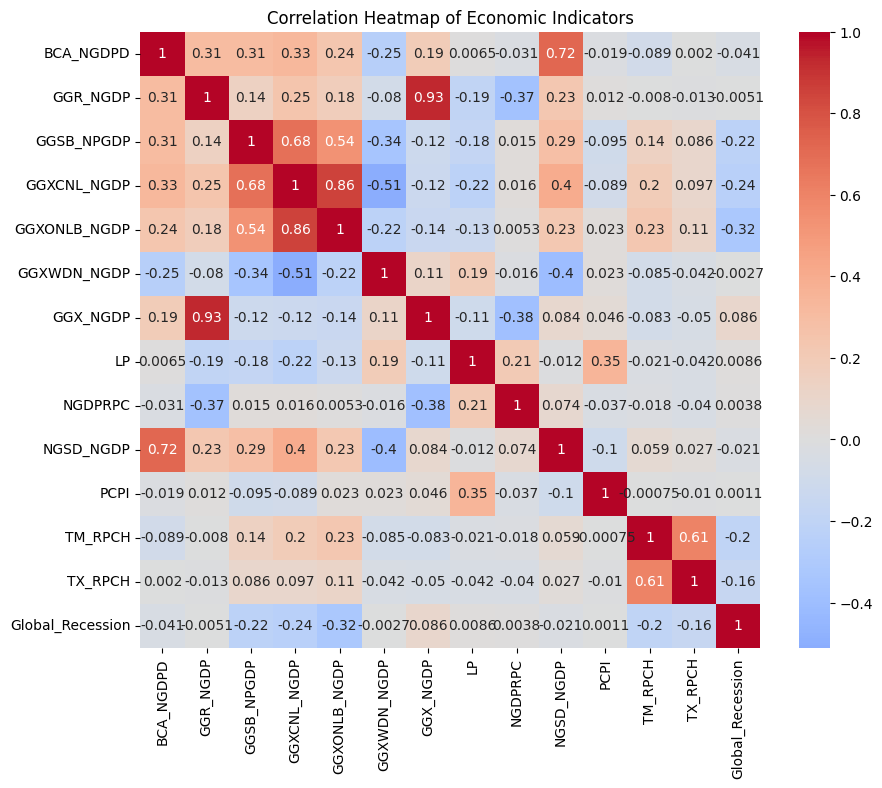

In [118]:
# --- 3. Exploratory Plots ---
# Heatmap
plt.figure(figsize=(10,8))
corr = df_filtered.drop(columns=["Country"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Economic Indicators")
plt.show()

create and a x and y dataset so that we can train our models

In [119]:
# Assuming df_filtered is your dataframe with Year as index
X = df_filtered.drop(columns=["Global_Recession", "Country"])  # features
y = df_filtered["Global_Recession"]                           # target

# Modelling portion on full dataset

## Model Training Functions

In [ ]:
def train_all_models(X_train, y_train, X_test, y_test, model_params=None):
    """
    Train all ML models with configurable parameters.
    
    Parameters:
    -----------
    X_train : DataFrame
        Training features
    y_train : Series
        Training target
    X_test : DataFrame
        Test features
    y_test : Series
        Test target
    model_params : dict, optional
        Dictionary with model configurations. If None, uses default parameters.
        Example: {'logit': {'C': 10, 'max_iter': 10000}, ...}
    
    Returns:
    --------
    tuple: (models_dict, results_df)
        - models_dict: Dictionary of trained model objects
        - results_df: DataFrame with training and test accuracies
    """
    # Default parameters
    if model_params is None:
        model_params = {
            'logit': {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 5000, 'random_state': 42},
            'rf': {'n_estimators': 150, 'max_depth': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'random_state': 42},
            'gb': {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 5, 'random_state': 42},
            'svc': {'C': 0.5, 'max_iter': 5000, 'dual': False, 'random_state': 42},
            'knn': {'n_neighbors': 10, 'weights': 'distance'},
            'nb': {},
            'mlp': {'hidden_layer_sizes': (30,), 'alpha': 0.001, 'max_iter': 500, 'early_stopping': True, 'random_state': 42}
        }
    
    # Train models
    logit = make_pipeline(StandardScaler(), LogisticRegression(**model_params['logit']))
    logit.fit(X_train, y_train)
    
    rf = RandomForestClassifier(**model_params['rf'])
    rf.fit(X_train, y_train)
    
    gb = GradientBoostingClassifier(**model_params['gb'])
    gb.fit(X_train, y_train)
    
    svc = make_pipeline(StandardScaler(), LinearSVC(**model_params['svc']))
    svc.fit(X_train, y_train)
    
    knn = KNeighborsClassifier(**model_params['knn'])
    knn.fit(X_train, y_train)
    
    nb = GaussianNB(**model_params['nb'])
    nb.fit(X_train, y_train)
    
    mlp = MLPClassifier(**model_params['mlp'])
    mlp.fit(X_train, y_train)
    
    ensemble = VotingClassifier(
        estimators=[("logit", logit.named_steps['logisticregression']), ("rf", rf), ("gb", gb)],
        voting="soft"
    )
    ensemble.fit(X_train, y_train)
    
    # Collect models
    models = {
        "Logistic Regression": logit,
        "Random Forest": rf,
        "Gradient Boosting": gb,
        "Linear SVM (scaled)": svc,
        "KNN": knn,
        "Naive Bayes": nb,
        "MLP": mlp,
        "Ensemble (RF+Logit+GB)": ensemble
    }
    
    # Calculate accuracies
    results = {
        name: [accuracy_score(y_train, model.predict(X_train)),
               accuracy_score(y_test, model.predict(X_test))]
        for name, model in models.items()
    }
    
    results_df = pd.DataFrame(results, index=["Training Accuracy", "Test Accuracy"]).T
    
    return models, results_df


In [ ]:
def plot_feature_importance(models, feature_names, title_prefix=""):
    """
    Plot feature importance for linear models (Logistic Regression, SVM) and tree-based models.
    
    Parameters:
    -----------
    models : dict
        Dictionary of trained models
    feature_names : list
        List of feature names
    title_prefix : str, optional
        Prefix to add to plot titles
    """
    logit = models["Logistic Regression"]
    rf = models["Random Forest"]
    gb = models["Gradient Boosting"]
    svc = models["Linear SVM (scaled)"]
    
    # Logistic Regression
    coef = logit.named_steps['logisticregression'].coef_[0]
    logit_importance = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coef,
        "Abs_Importance": np.abs(coef)
    }).sort_values(by="Abs_Importance", ascending=False)
    
    # Random Forest
    rf_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": rf.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    
    # Gradient Boosting
    gb_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": gb.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    
    # Linear SVM
    coef_svm = svc.named_steps['linearsvc'].coef_[0]
    svc_importance = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coef_svm,
        "Abs_Importance": np.abs(coef_svm)
    }).sort_values(by="Abs_Importance", ascending=False)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(16,12))
    
    # Logistic Regression
    logit_sorted = logit_importance.sort_values(by="Abs_Importance", ascending=True)
    axes[0,0].barh(logit_sorted["Feature"], logit_sorted["Coefficient"], color="skyblue")
    axes[0,0].set_title(f"{title_prefix}Logistic Regression Feature Importance")
    axes[0,0].axvline(0, color="black", linewidth=0.8)
    
    # Random Forest
    rf_sorted = rf_importance.sort_values(by="Importance", ascending=True)
    axes[0,1].barh(rf_sorted["Feature"], rf_sorted["Importance"], color="skyblue")
    axes[0,1].set_title(f"{title_prefix}Random Forest Feature Importance")
    
    # Gradient Boosting
    gb_sorted = gb_importance.sort_values(by="Importance", ascending=True)
    axes[1,0].barh(gb_sorted["Feature"], gb_sorted["Importance"], color="skyblue")
    axes[1,0].set_title(f"{title_prefix}Gradient Boosting Feature Importance")
    
    # Linear SVM
    svc_sorted = svc_importance.sort_values(by="Abs_Importance", ascending=True)
    axes[1,1].barh(svc_sorted["Feature"], svc_sorted["Coefficient"], color="skyblue")
    axes[1,1].set_title(f"{title_prefix}Linear SVM Feature Importance")
    axes[1,1].axvline(0, color="black", linewidth=0.8)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def make_predictions(models, df_predict):
    """
    Make predictions using all trained models.
    
    Parameters:
    -----------
    models : dict
        Dictionary of trained models
    df_predict : DataFrame
        Features to predict on
    
    Returns:
    --------
    DataFrame: Predictions from all models
    """
    predictions = pd.DataFrame(
        {name: model.predict(df_predict) for name, model in models.items()},
        index=df_predict.index
    )
    return predictions

In [121]:
# --- Chronological split (80% train, 20% test) ---
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [122]:
# Train models using the modular function
models, summary_df = train_all_models(X_train, y_train, X_test, y_test)
print(summary_df)

                        Training Accuracy  Test Accuracy
Logistic Regression              0.827245       0.811550
Random Forest                    0.876712       0.844985
Gradient Boosting                0.908676       0.848024
Linear SVM (scaled)              0.814307       0.808511
KNN                              1.000000       0.726444
Naive Bayes                      0.792998       0.784195
MLP                              0.792998       0.784195
Ensemble (RF+Logit+GB)           0.892694       0.851064


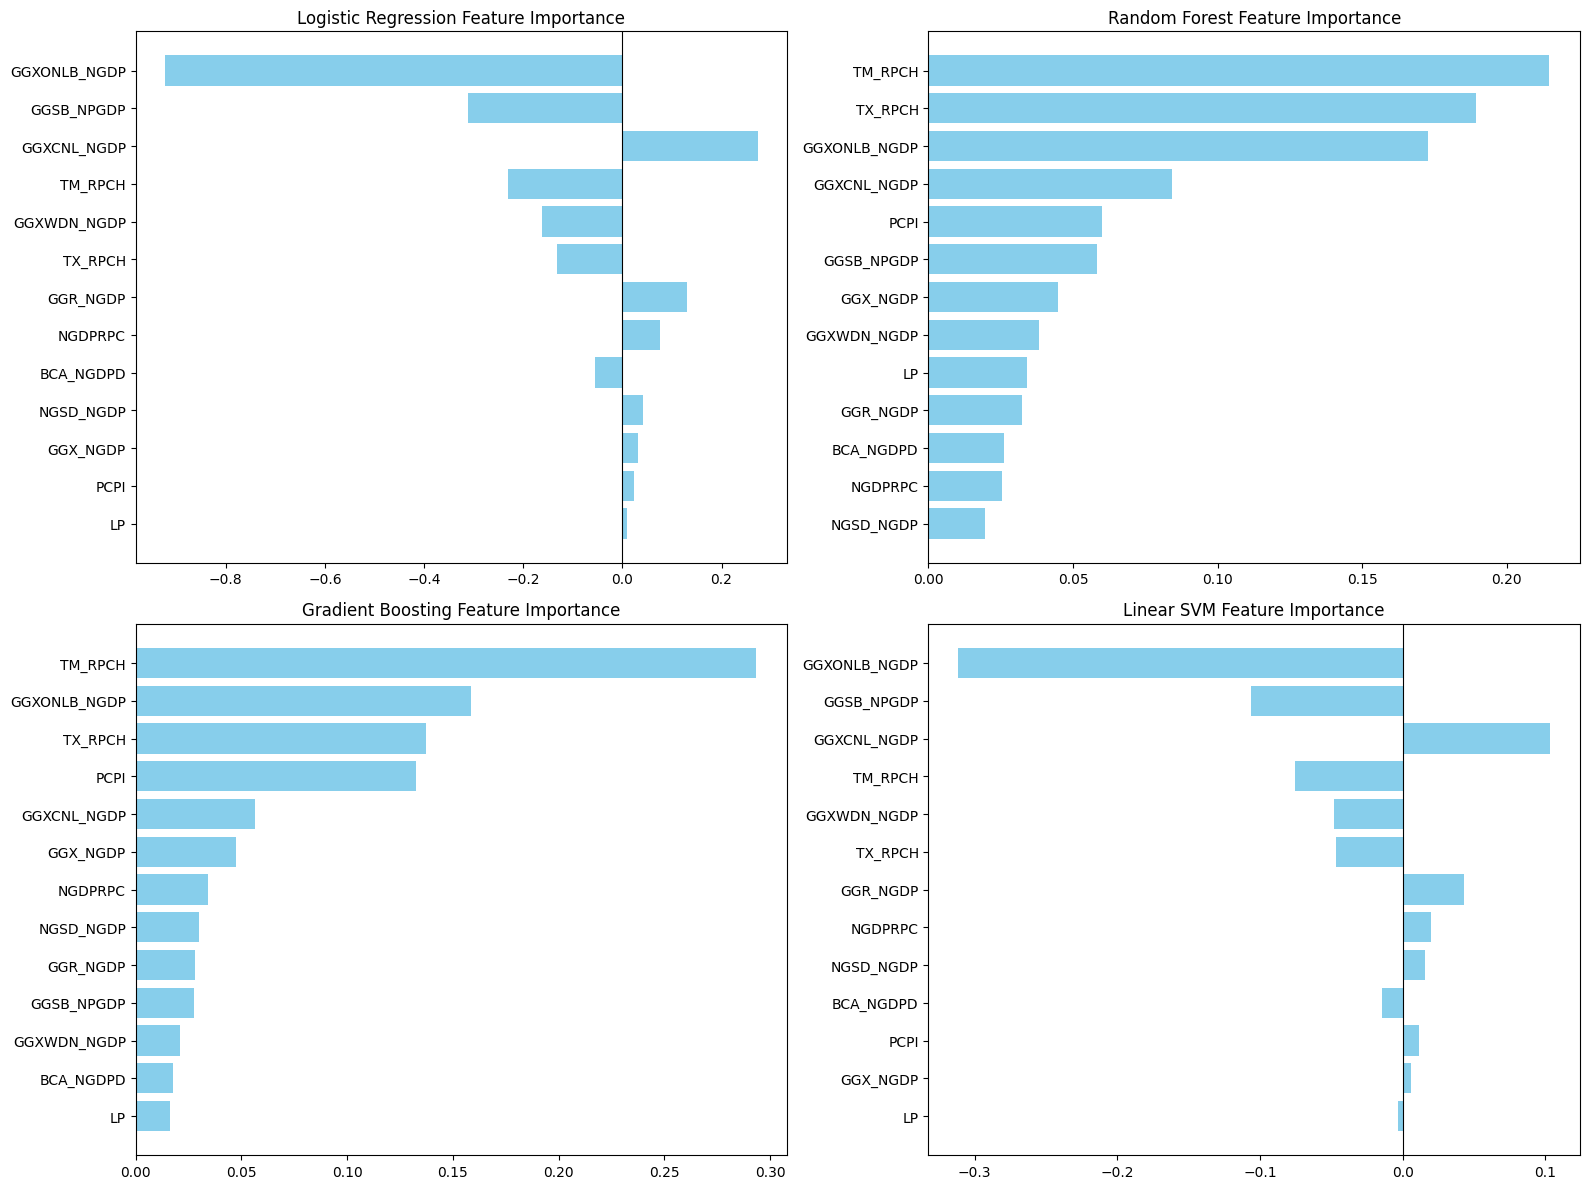

In [123]:
# Plot feature importance
plot_feature_importance(models, X_train.columns.tolist())

In [124]:
# Make predictions for future years
predictions = make_predictions(models, df_predict)
print(predictions)

      Logistic Regression  Random Forest  Gradient Boosting  \
Year                                                          
2025                    0              0                  0   
2026                    0              0                  0   
2027                    0              0                  0   
2028                    0              0                  0   
2029                    0              0                  0   
...                   ...            ...                ...   
2026                    0              0                  0   
2027                    0              0                  0   
2028                    0              0                  0   
2029                    0              0                  0   
2030                    0              0                  0   

      Linear SVM (scaled)  KNN  Naive Bayes  MLP  Ensemble (RF+Logit+GB)  
Year                                                                      
2025                    0    0

## Reduced set

In [125]:
# --- Select reduced feature set ---
selected_features = ['TM_RPCH', 'GGXONLB_NGDP', 'TX_RPCH', 'GGXCNL_NGDP', 'PCPI']

# --- Chronological split (80% train, 20% test) ---
split_index = int(len(X) * 0.8)
X_train_reduced = X.iloc[:split_index][selected_features]
X_test_reduced  = X.iloc[split_index:][selected_features]
y_train         = y.iloc[:split_index]
y_test          = y.iloc[split_index:]

# Train models with reduced features
models_reduced, summary_df_reduced = train_all_models(X_train_reduced, y_train, X_test_reduced, y_test)
print(summary_df_reduced)

                        Training Accuracy  Test Accuracy
Logistic Regression              0.824201       0.814590
Random Forest                    0.869863       0.854103
Gradient Boosting                0.903349       0.851064
Linear SVM (scaled)              0.813546       0.814590
KNN                              1.000000       0.844985
Naive Bayes                      0.792998       0.784195
MLP                              0.813546       0.844985
Ensemble (RF+Logit+GB)           0.888128       0.851064


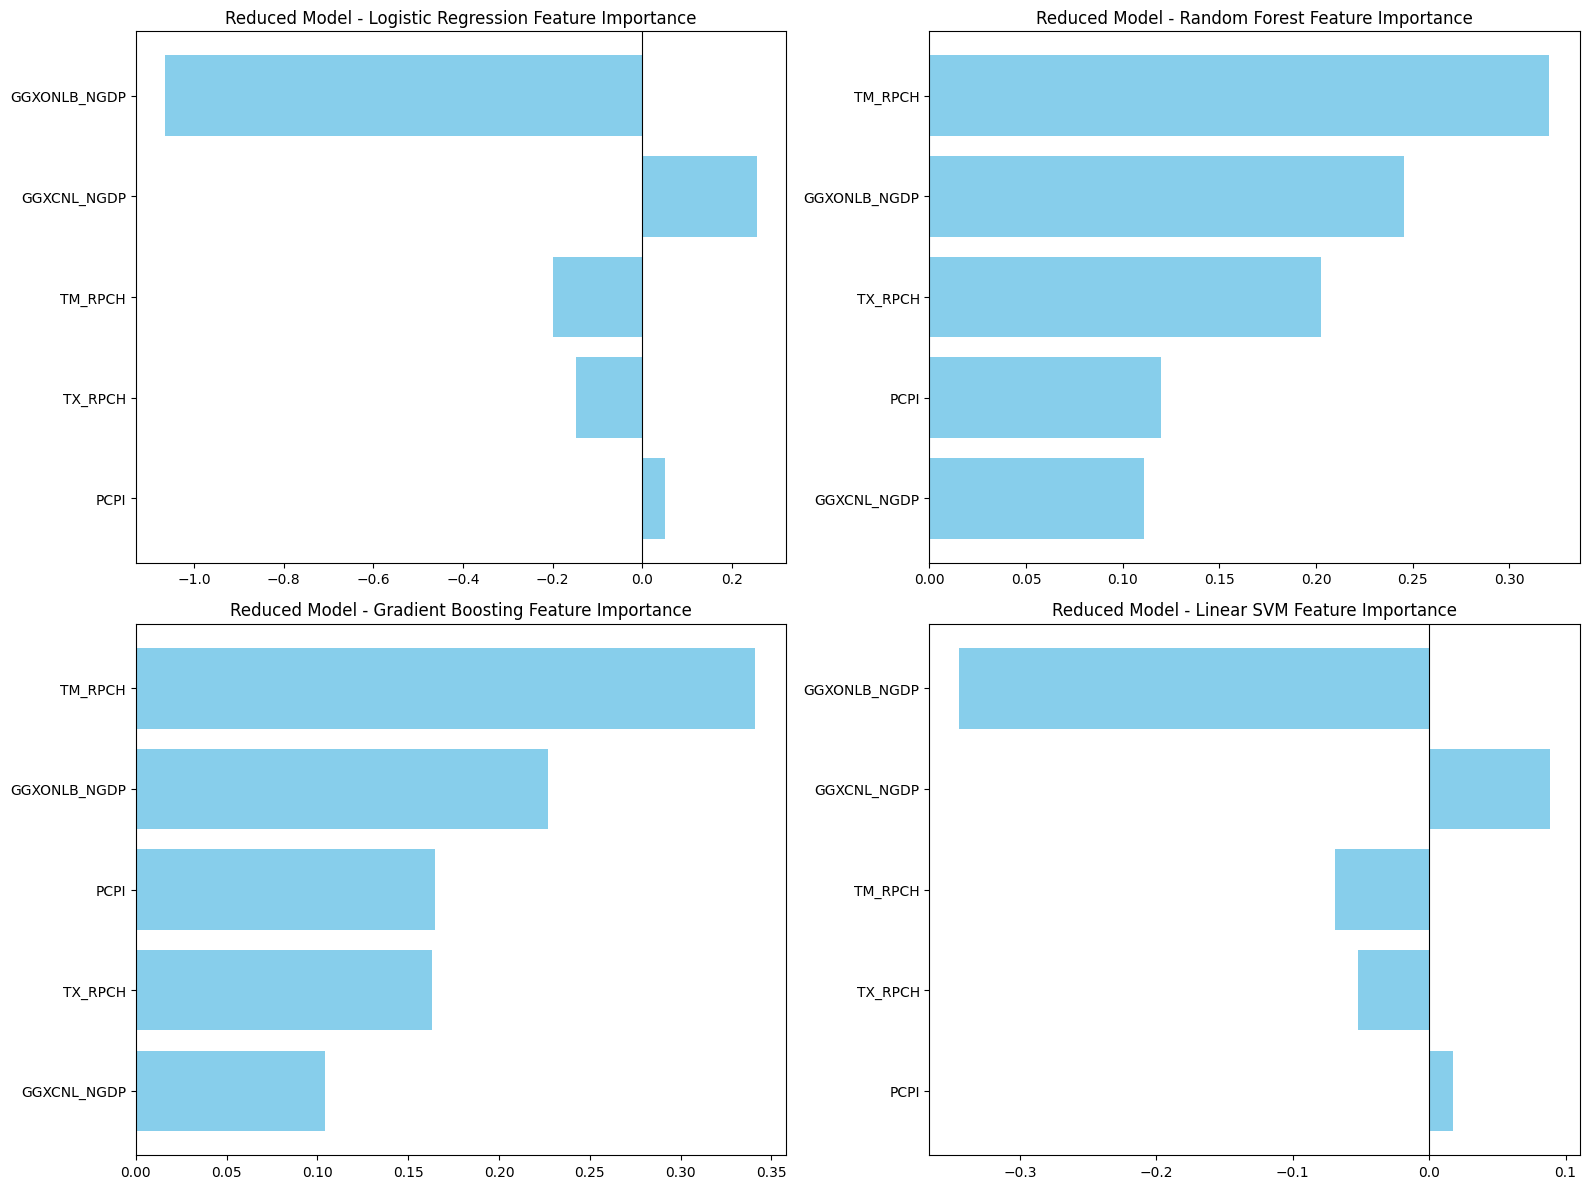

In [126]:
# Plot feature importance for reduced model
plot_feature_importance(models_reduced, selected_features, title_prefix="Reduced Model - ")

In [127]:
# Make predictions with reduced features
df_predict_restricted = df_predict[selected_features]
predictions_restricted = make_predictions(models_reduced, df_predict_restricted)
print(predictions_restricted)

      Logistic Regression  Random Forest  Gradient Boosting  \
Year                                                          
2025                    0              0                  0   
2026                    0              0                  0   
2027                    0              0                  0   
2028                    0              0                  0   
2029                    0              0                  0   
...                   ...            ...                ...   
2026                    0              0                  0   
2027                    0              0                  0   
2028                    0              0                  0   
2029                    0              0                  0   
2030                    0              0                  0   

      Linear SVM (scaled)  KNN  Naive Bayes  MLP  Ensemble (RF+Logit+GB)  
Year                                                                      
2025                    0    0

# Splitting data per continent

In [128]:
# Map countries to continents (same logic as before)
try:
    import pycountry
    import pycountry_convert as pc
    
    def country_to_continent(name):
        try:
            lookup_name = name.replace('_', ' ')
            country = pycountry.countries.lookup(lookup_name)
            alpha2 = country.alpha_2
            cc = pc.country_alpha2_to_continent_code(alpha2)
            continent_map = {
                'AF': 'Africa',
                'AS': 'Asia',
                'EU': 'Europe',
                'NA': 'North_America',
                'OC': 'Oceania',
                'SA': 'South_America'
            }
            return continent_map.get(cc, 'Unknown')
        except Exception:
            return 'Unknown'
except ImportError:
    # Fallback mapping for common countries (extend as needed)
    fallback = {
        'United_States': 'North_America', 'Canada': 'North_America', 'Mexico': 'North_America',
        'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'Afghanistan': 'Asia',
        'Korea': 'Asia', 'Indonesia': 'Asia', 'Thailand': 'Asia', 'Vietnam': 'Asia',
        'Germany': 'Europe', 'France': 'Europe', 'United_Kingdom': 'Europe', 'Italy': 'Europe',
        'Spain': 'Europe', 'Russia': 'Europe', 'Turkey': 'Europe', 'Poland': 'Europe',
        'Brazil': 'South_America', 'Argentina': 'South_America', 'Chile': 'South_America',
        'Colombia': 'South_America', 'Peru': 'South_America', 'Venezuela': 'South_America',
        'Australia': 'Oceania', 'New_Zealand': 'Oceania',
        'South_Africa': 'Africa', 'Nigeria': 'Africa', 'Egypt': 'Africa', 'Zimbabwe': 'Africa',
        'Kenya': 'Africa', 'Ethiopia': 'Africa', 'Morocco': 'Africa',
        # Additional countries...
        'Albania': 'Europe', 'Algeria': 'Africa', 'Austria': 'Europe', 'Barbados': 'North_America',
        'Belgium': 'Europe', 'Bolivia': 'South_America', 'Bosnia_and_Herzegovina': 'Europe',
        'Bulgaria': 'Europe', 'Cabo_Verde': 'Africa', 'Costa_Rica': 'North_America',
        'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech_Republic': 'Europe', 'Denmark': 'Europe',
        'Dominican_Republic': 'North_America', 'Estonia': 'Europe', 'Finland': 'Europe',
        'Hungary': 'Europe', 'Iceland': 'Europe', 'Ireland': 'Europe',
        'Islamic_Republic_of_Iran': 'Asia', 'Israel': 'Asia', 'Jordan': 'Asia',
        'Kazakhstan': 'Asia', 'Latvia': 'Europe', 'Lebanon': 'Asia', 'Lithuania': 'Europe',
        'Luxembourg': 'Europe', 'Malta': 'Europe', 'Netherlands': 'Europe',
        'North_Macedonia': 'Europe', 'Norway': 'Europe', 'Pakistan': 'Asia',
        'Panama': 'North_America', 'Paraguay': 'South_America', 'Portugal': 'Europe',
        'Romania': 'Europe', 'Saudi_Arabia': 'Asia', 'Serbia': 'Europe', 'Seychelles': 'Africa',
        'Slovak_Republic': 'Europe', 'Slovenia': 'Europe', 'Sweden': 'Europe',
        'Switzerland': 'Europe', 'Syria': 'Asia', 'Taiwan_Province_of_China': 'Asia',
        'Trinidad_and_Tobago': 'North_America', 'Türkiye': 'Europe', 'Uruguay': 'South_America'
    }
    
    def country_to_continent(name):
        return fallback.get(name.replace(' ', '_'), 'Unknown')

# --- Add Continent column ---
df_filtered_copy = df_pivot.copy()
df_filtered_copy['Continent'] = df_filtered_copy['Country'].astype(str).apply(country_to_continent)

# --- Map continents to economy groups ---
continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_filtered_copy['EconomyGroup'] = df_filtered_copy['Continent'].map(continent_to_economy)

# --- Create Lower and Upper economy DataFrames ---
df_Lower_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Lower_Economies'].drop(columns=['Continent','EconomyGroup'])
df_Upper_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Upper_Economies'].drop(columns=['Continent','EconomyGroup'])

# --- Print summary ---
print("Created economy-specific DataFrames:")
print(f" - Lower_Economies: df_Lower_Economies (rows: {len(df_Lower_Economies)})")
print(f" - Upper_Economies: df_Upper_Economies (rows: {len(df_Upper_Economies)})")


Created economy-specific DataFrames:
 - Lower_Economies: df_Lower_Economies (rows: 448)
 - Upper_Economies: df_Upper_Economies (rows: 1487)


In [129]:
df_Lower_Economies

,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,,,,
2001,Brazil,-4.445,36.334,-2.721,-3.468,3.130,51.486,39.802,177.004,4497.210,14.297,1.151793e+13,3.027,8.702,0
2002,Brazil,-1.845,40.346,-3.280,-4.149,3.356,59.934,44.495,179.228,4577.002,15.604,1.249119e+13,-11.773,8.471,0
2003,Brazil,0.393,35.887,-3.697,-5.401,3.553,54.259,41.288,181.378,4574.367,17.250,1.432920e+13,-2.674,14.237,0
2004,Brazil,1.339,36.726,-2.119,-2.955,4.051,50.186,39.681,183.470,4782.684,19.251,1.527464e+13,13.783,16.029,0
2005,Brazil,1.310,38.507,-2.293,-3.364,3.865,47.915,41.870,185.518,4881.323,18.515,1.632404e+13,9.310,10.304,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Uruguay,-1.662,28.217,-2.679,-2.703,-0.559,59.226,30.919,3.520,568824.277,13.455,1.203330e+02,5.311,3.505,0
2027,Uruguay,-1.826,28.169,-2.566,-2.584,-0.403,59.041,30.753,3.528,581143.025,13.186,1.260280e+02,5.100,3.432,0
2028,Uruguay,-1.875,28.160,-2.408,-2.412,-0.238,58.910,30.572,3.535,593587.737,13.073,1.318620e+02,5.022,3.371,0


In [130]:
df_Upper_Economies

,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,,,,
1990,Australia,-4.859,30.243,-0.286,-0.232,1.871,9.564,30.475,17.170,57478.994,22.988,57.450,-3.865,7.537,1
1991,Australia,-3.287,30.271,-2.047,-2.788,-0.978,12.595,33.059,17.379,56229.476,18.349,59.350,-2.597,12.923,1
1992,Australia,-3.283,29.312,-3.809,-4.745,-3.115,18.217,34.057,17.557,57101.179,19.263,59.925,6.853,6.422,1
1993,Australia,-3.036,29.412,-4.053,-4.727,-2.898,22.052,34.138,17.719,58797.715,21.103,60.975,5.161,8.375,1
1994,Australia,-4.491,29.949,-3.171,-3.793,-1.783,23.232,33.742,17.893,61063.073,21.604,62.150,14.287,7.940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,United_States,-3.173,32.514,-5.497,-5.490,-1.475,99.233,38.004,344.396,70106.690,18.430,331.035,1.168,1.807,0
2027,United_States,-3.045,32.754,-5.323,-5.353,-1.379,100.428,38.107,346.436,71075.474,18.693,338.021,2.146,2.978,0
2028,United_States,-2.623,32.409,-5.615,-5.615,-1.705,101.448,38.024,348.483,72156.998,19.140,345.307,2.056,3.047,0


# Model it based on lower and upper Economies

## Upper Economy

In [131]:
# Assuming df_filtered is your dataframe with Year as index
X = df_Upper_Economies.drop(columns=["Global_Recession", "Country"])  # features
y = df_Upper_Economies["Global_Recession"]       

# --- Chronological split (80% train, 20% test) ---
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]                    # target

In [132]:
# Train models for Upper Economies
models_upper, summary_df_upper = train_all_models(X_train, y_train, X_test, y_test)
print(summary_df_upper)

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                        Training Accuracy  Test Accuracy
Logistic Regression              0.854500       0.852349
Random Forest                    0.904962       0.869128
Gradient Boosting                0.943650       0.882550
Linear SVM (scaled)              0.857864       0.845638
KNN                              1.000000       0.788591
Naive Bayes                      0.825904       0.825503
MLP                              0.825904       0.825503
Ensemble (RF+Logit+GB)           0.911690       0.879195


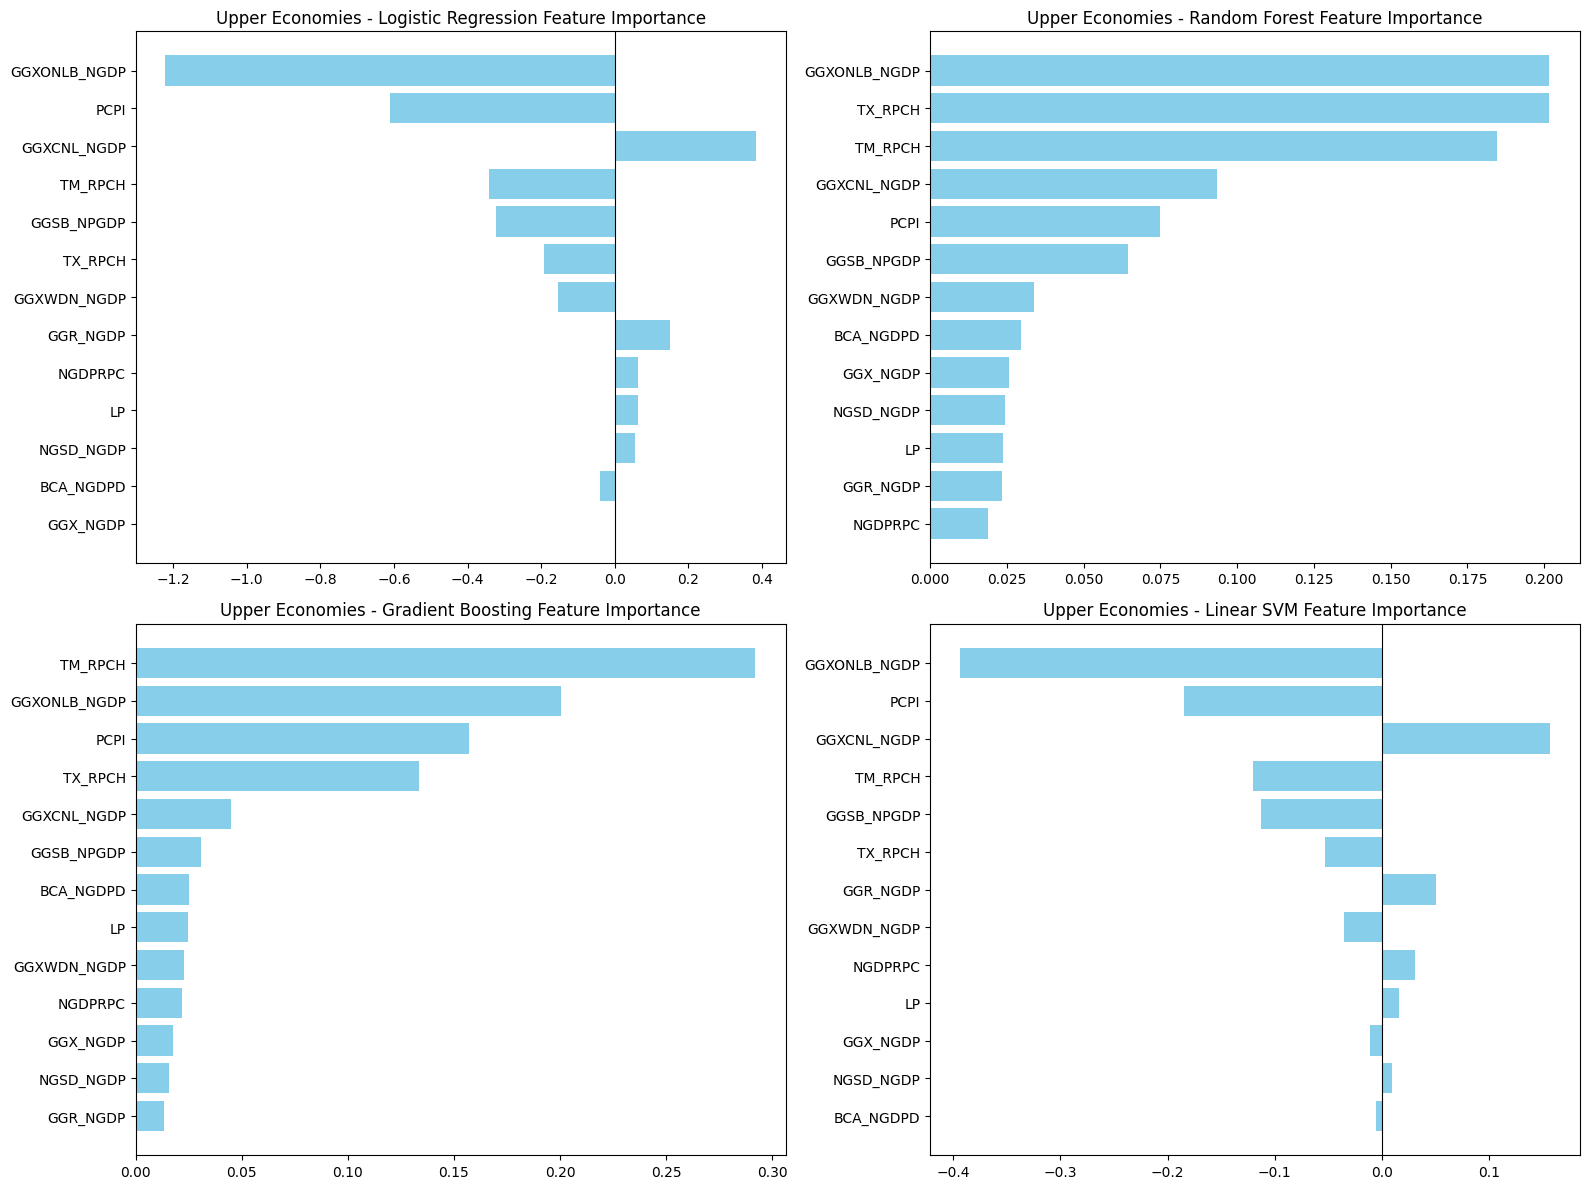

In [133]:
# Plot feature importance for Upper Economies
plot_feature_importance(models_upper, X_train.columns.tolist(), title_prefix="Upper Economies - ")

## Lower Economy

In [134]:
# Assuming df_filtered is your dataframe with Year as index
X = df_Lower_Economies.drop(columns=["Global_Recession", "Country"])  # features
y = df_Lower_Economies["Global_Recession"]                           # target

# --- Chronological split (80% train, 20% test) ---
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [135]:
# Train models for Lower Economies
models_lower, summary_df_lower = train_all_models(X_train, y_train, X_test, y_test)
print(summary_df_lower)

                        Training Accuracy  Test Accuracy
Logistic Regression              0.840782       0.866667
Random Forest                    0.888268       0.900000
Gradient Boosting                0.977654       0.900000
Linear SVM (scaled)              0.835196       0.866667
KNN                              1.000000       0.822222
Naive Bayes                      0.829609       0.855556
MLP                              0.226257       0.144444
Ensemble (RF+Logit+GB)           0.921788       0.888889


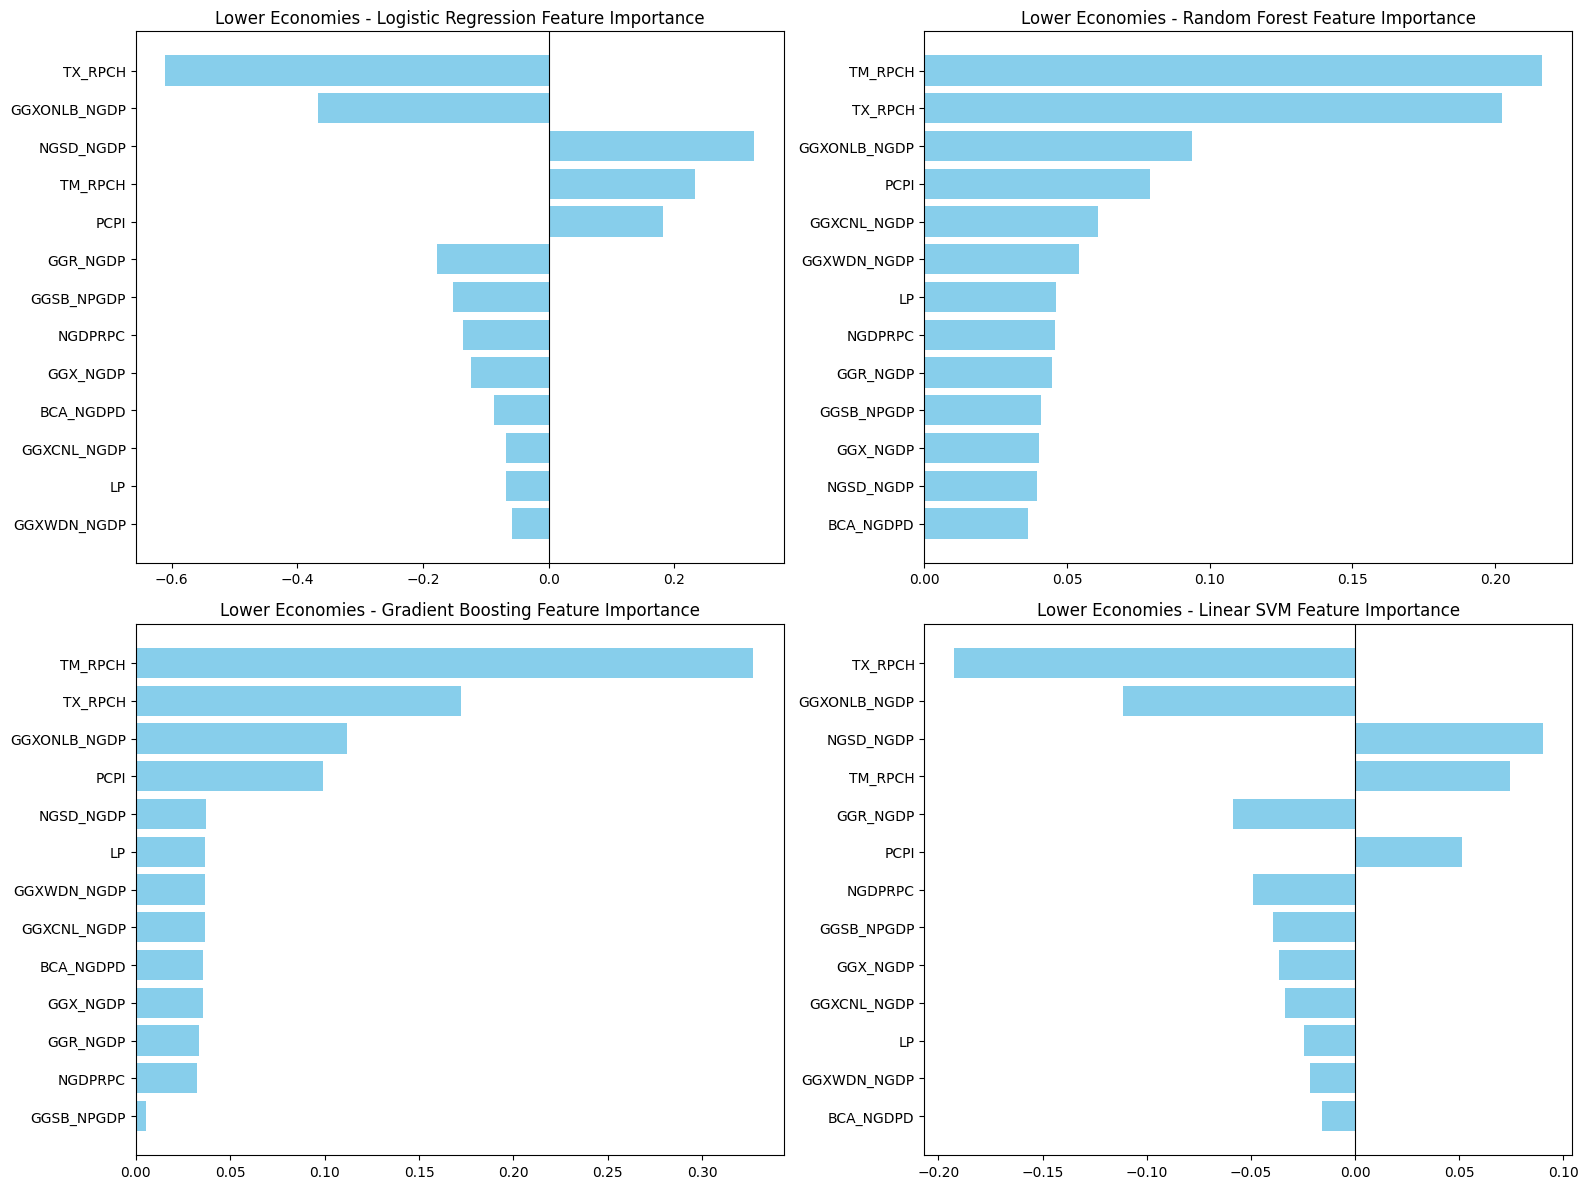

In [136]:
# Plot feature importance for Lower Economies
plot_feature_importance(models_lower, X_train.columns.tolist(), title_prefix="Lower Economies - ")